In [119]:
# TODO
# Create implementation of Black-Scholes model
# Plot vol surface
# Get some historical options pricing data?

In [1]:
# Imports and setup
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize

In [2]:
# Sample M paths of length T with N steps from a GBM with infinitessimal mean mu and stdev sigma
def Sample_Geometric_Brownian(S0,mu,sigma,N,T,M):
    dt = T/N
    # np.random.normal takes stdev as parameter, hence sqrt(dt)
    St = np.exp((mu - sigma**2 / 2) * dt + np.random.normal(0, np.sqrt(dt), (M,N-1)).T)
    St = np.vstack([np.ones(M), St])
    St = S0 * St.cumprod(axis=0)
    return St

In [3]:
# Return the value of a call option on an underlying with price St at time t given the required parameters, according to the vanilla B-S-M model
def C_series(t,St,T,K,r,sigma): # time given as a vector
    diff = T-t
    diff[diff<=0]=0.00000000001
    d_plus = 1/(sigma*np.sqrt(diff))*(np.log(St/K)+(r+(sigma**2)/2)*(diff))
    d_minus = d_plus - sigma*np.sqrt(diff)
    return norm.cdf(d_plus)*St - norm.cdf(d_minus)*K*np.exp(-r*(diff))

def C_pointwise(t,St,T,K,r,sigma): # time given as a single point
    epsilon = max((T-t),0.00000000001)
    d_plus = 1/(sigma*np.sqrt(epsilon))*(np.log(St/K)+(r+(sigma**2)/2)*(epsilon))
    d_minus = d_plus - sigma*np.sqrt(epsilon)
    return norm.cdf(d_plus)*St - norm.cdf(d_minus)*K*np.exp(-r*(epsilon))

In [4]:
# Return the value of a put option on an underlying with price St at time t according to vanilla B-S-M and put-call parity
def P_series(t,St,T,K,r,sigma):
    diff = T-t
    diff[diff<=0]=0.00000000001
    C = C_series(t,St,T,K,r,sigma)
    return K*np.exp(-r*diff)-St+C

def P_pointwise(t,St,T,K,r,sigma):
    epsilon = max((T-t),0.00000000001)
    C = C_pointwise(t,St,T,K,r,sigma)
    return K*np.exp(-r*epsilon)-St+C

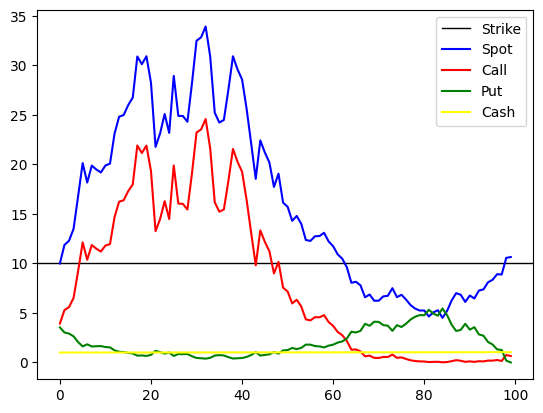

7.290361042615771


In [5]:
# Lets set some parameters and value a vanilla european call option

# SETUP
np.random.seed(0) # Fix random seed to produce replicable results
S0 = 10 # Set starting value of stock price for simulated path
mu = 0 # Set drift term for stock price
sigma = 1 # Set vol term for stock price
N = 100 # Set number of points in simulation
T = 1 # Set terminal/exercise time of simulation
S = Sample_Geometric_Brownian(S0,mu,sigma,N,T,1) # Sample stock price with parameters given above
K = 10 # Set strike price of call option
r = 0.04 # Force of interest (annualized risk-free rate, continuously compounded)
time = np.cumsum(np.ones(S.shape[0])*T/N) # Get array of points in time up to exercise time
call = [] # We need an array to store the call option values in
put = []
cash = []

for t in range(len(time)): # For each point in time
    c = C_pointwise(time[t],S[t,0],T,K,r,sigma) # Get the option valuation at that time, given the corresponding underlying value and parameters from above
    call.append(c) # append this valuation to our array
    p = P_pointwise(time[t],S[t,0],T,K,r,sigma)
    put.append(p)
    m = np.exp(time[t]*r)
    cash.append(m)

call = np.array(call)
put = np.array(put)
cash = np.array(cash)

# plot stuff
plt.axhline(y=K, color='black', linestyle='-',lw=1,label="Strike")
plt.plot(S, label="Spot", color="blue")
plt.plot(call, label="Call",color="red")
plt.plot(put, label="Put",color="green")
plt.plot(cash, label="Cash",color="yellow")
plt.legend()
plt.show()

print(C_pointwise(0,69,0.5,70,0.06,0.35))

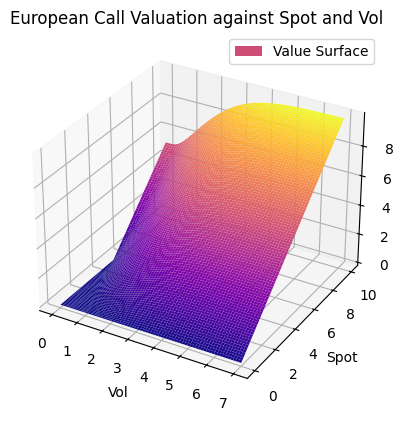

In [6]:
t = 0
vol = np.linspace(0.01, 7, 70)
S = np.linspace(0.01, 10, 100)

def f(vol, S):
    return C_pointwise(t,S,1,5,0.04,vol)

X, Y = np.meshgrid(vol, S)
Z = f(X, Y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='plasma', edgecolor='none', label='Value Surface')
ax.set_title('European Call Valuation against Spot and Vol')
ax.legend()
ax.set_xlabel('Vol')
ax.set_ylabel('Spot')
plt.show()

/var/folders/bx/mt7qyk8x4y3cr63zdm0f62j00000gn/T/ipykernel_86192/3182137951.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  d_plus = 1/(sigma*np.sqrt(epsilon))*(np.log(St/K)+(r+(sigma**2)/2)*(epsilon))


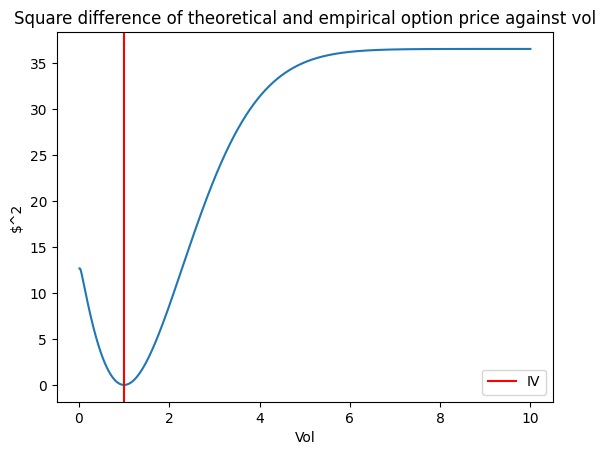

In [7]:
# Estimate IV from option price and other parameters
S = 10
K = 10
t = 0
T = 1
r = 0.04
sigma_star = 1
V_star = C_pointwise(t,S,T,K,r,sigma_star)

def err_function(sigma):
    return (C_pointwise(t,S,T,K,r,sigma)-V_star)**2

s = np.linspace(0.01,10,1000)
plt.plot(s,err_function(s))
plt.axvline(x=minimize_scalar(err_function).x,color='r',label='IV')
plt.xlabel("Vol")
plt.ylabel("$^2")
plt.title("Square difference of theoretical and empirical option price against vol")
plt.legend()
plt.show()

In [8]:
# Function to estimate IV
def estimate_IV(t,T,S,K,r,V_star):
    
    def err_function(sigma):
        return (C_pointwise(t,S,T,K,r,sigma)-V_star)**2

    sigma_hat = minimize_scalar(err_function).x

    return sigma_hat

V_star = C_pointwise(0,10,1,10,0.04,5)

print(estimate_IV(0,1,10,10,0.04,V_star))

4.99999999829997


/var/folders/bx/mt7qyk8x4y3cr63zdm0f62j00000gn/T/ipykernel_86192/3182137951.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  d_plus = 1/(sigma*np.sqrt(epsilon))*(np.log(St/K)+(r+(sigma**2)/2)*(epsilon))


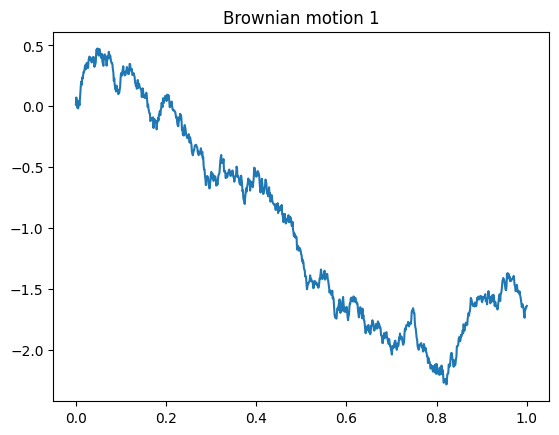

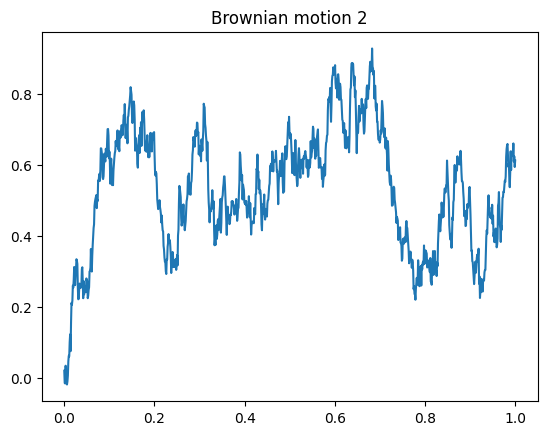

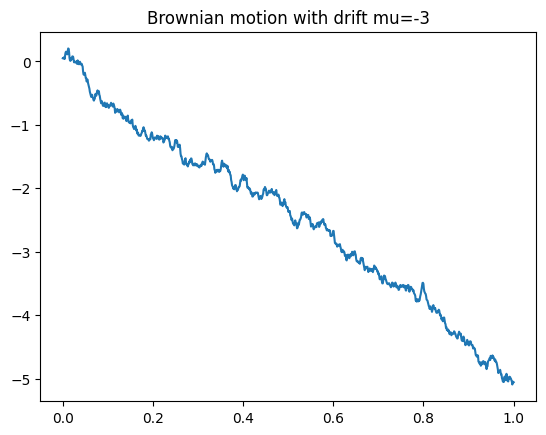

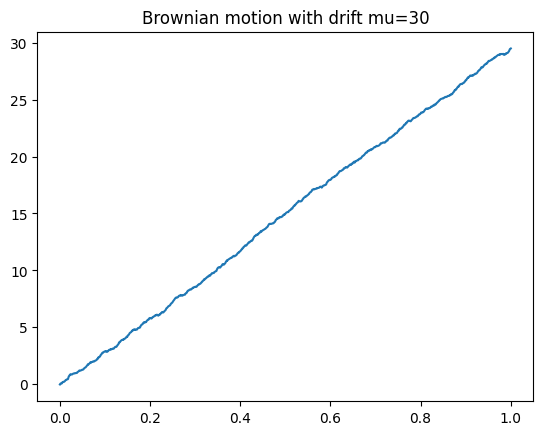

In [9]:
ts = np.linspace(0,1,1000)

Xs = np.random.normal(0,1,1000)
W = np.cumsum(Xs)/np.sqrt(1000)
plt.plot(ts,W)
plt.title("Brownian motion 1")
plt.show()

Xs = np.random.normal(0,1,1000)
W = np.cumsum(Xs)/np.sqrt(1000)
plt.plot(ts,W)
plt.title("Brownian motion 2")
plt.show()

Xs = np.random.normal(0,1,1000)
W = np.cumsum(Xs)/np.sqrt(1000) + -3*ts
plt.plot(ts,W)
plt.title("Brownian motion with drift mu=-3")
plt.show()

Xs = np.random.normal(0,1,1000)
W = np.cumsum(Xs)/np.sqrt(1000) + 30*ts
plt.plot(ts,W)
plt.title("Brownian motion with drift mu=30")
plt.show()

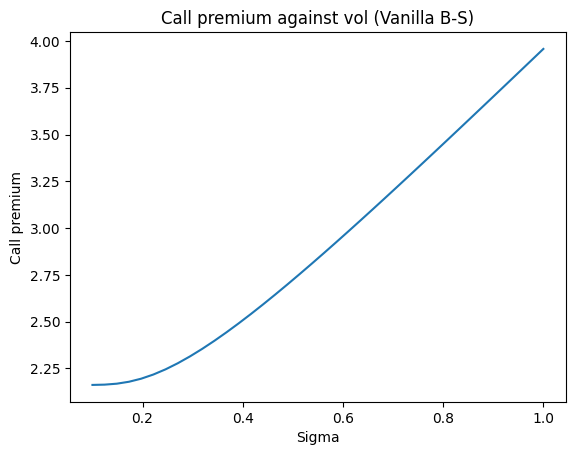

In [17]:
# Financial maths problem sheet 10, q2
# plot graph of call option price as function of vol

S=15
K=13
t=0
T=0.25
r=0.05

sigma=np.linspace(0.1,1,38)

vals = C_pointwise(t,S,T,K,r,sigma)
plt.plot(sigma,vals)
plt.xlabel("Sigma")
plt.ylabel("Call premium")
plt.title("Call premium against vol (Vanilla B-S)")
plt.show()